In [1]:
import sys
sys.path.append('D:/ORG India/Image-Retreival/Mac/Benchmark')

In [8]:
import cv2
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from Benchmark.SaliencyMap import generate_saliency_matrix,plot_saliency_map

class MAC():
    def __init__(self,L):
        self.L = L
        self.lastconvfeature = None
        self.max_pool_2d = None

    def calculate_centers(self,w,h):
        wl = []
        hl = []
        s  = []
        centers = dict()
        for l in range(2,self.L+1):
            wi = (2 * w)/(l+1)
            hi = (2 * h)/(l+1)
            s_val = max(wi,hi)
            s.append(s_val)
            wl.append(wi)
            hl.append(hi)
            it_centers = []
            for i in range(1,l+1):
                for j in range(1,l+1):
                    bw =  (w-wi)/(l-1)
                    bh =  (h-hi)/(l-1)
                    cx =  (wi/2) + (i-1)*bw
                    cy =  (hi/2) + (j-1)*bh
                    it_centers.append([int(cx),int(cy)])
            centers[int(s_val)] = it_centers
        return centers

    def patches(self,side,center,image):
        h,w,c = image.shape
        half_side = side / 2
        left_corner_x = int(center[0] - half_side) 
        left_corner_y = int(center[1] - half_side)
        if(left_corner_x < 0):
            left_corner_x = 0
        if(left_corner_y < 0):
            left_corner_y = 0
        stridex = int(left_corner_x+side)
        stridey = int(left_corner_y+side)
        if(stridex>h):
            stridex = int(left_corner_x + side-(stridex-h))
        if(stridey>w):
            stridey = int(left_corner_y + side-(stridey-w))
        #print(left_corner_x,stridex,left_corner_y,stridey)
        image_patch = image[left_corner_x:stridex,left_corner_y:stridey,:]
        return(image_patch)

    def all_patches(self,centers,img):
        all_patches = []
        for sides,allcenters in centers.items():
            for single_centers in allcenters:
                all_patches.append(self.patches(sides,single_centers,img))
        assert len(all_patches)+1 == sum([i**2 for i in range(1,self.L+1)])
        return all_patches

    def show_patches(self,all_patches):
        for sap in all_patches:
            plt.imshow(sap)
            plt.show()

    def featuremodel(self):
        self.max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(8, 8),strides=(1, 1), padding='valid')
        model = tf.keras.applications.inception_v3.InceptionV3(
            include_top=True,
            weights='imagenet',
            pooling=None,
            classes=1000,
            classifier_activation='softmax'
        )
        convname = re.compile(r'conv2d_*')
        convlayerlist = []
        for layers in model.layers:
            mo1 = bool(re.match(convname,layers.name))
            if(mo1):
                convlayerlist.append(layers.name)
        self.lastconvfeature = tf.keras.Model(
            inputs = model.inputs,
            outputs= model.get_layer(convlayerlist[-1]).output)
        print("Feature Maps Generated")

    def extractfeature(self,ap):
        resized_ap = np.resize(ap,(1,299,299,3))
        lastconvoutput = self.lastconvfeature(resized_ap)
        finalfeature = self.max_pool_2d(lastconvoutput)
        finalfeature = np.squeeze(finalfeature)
        return finalfeature


    def create_source_embedding_from_cvimage(self,list_of_image_array):
        print('%d Cv Image Images found'%len(list_of_image_array))
        embeddingList=[]
        embedding_with_meta = []
        for eachImage in list_of_image_array:
            distlist = []
            # eachImage = cv2.imread(os.path.join("D:/ORG India/data/all_data/",eachFile))
            centers = self.calculate_centers(eachImage.shape[0],eachImage.shape[1])
            all_patches = self.all_patches(centers,eachImage)
            extractedfeature = []
            for ap in all_patches:
                returnedfeature = self.extractfeature(ap)
                extractedfeature.append(returnedfeature)
            embedding_with_meta.append({"name":"eachFile","embedding":extractedfeature})
        print("Embedding Created from CV Image")
        return embedding_with_meta

    def scoring_function(self,target_embedding,source_embedding_with_meta):
        distlist = []
        minindex = 1000
        print(source_embedding_with_meta)
        for ef in source_embedding_with_meta["embedding"]:
            dist = np.linalg.norm(ef - target_embedding)
            distlist.append(dist)
            if(min(distlist)<minindex):
                minindex = min(distlist)
        return minindex

Feature Maps Generated
4 Cv Image Images found
Embedding Created from CV Image
{'name': 'eachFile', 'embedding': [array([ 5.5819707 ,  3.4060898 , -2.219943  ,  0.0727191 ,  0.982061  ,
       -3.598341  ,  1.9975696 , -0.6231193 ,  3.2844982 ,  0.70929694,
        7.0708084 ,  4.861724  ,  8.638559  , 14.006632  ,  5.538964  ,
        4.492065  , -1.4132214 ,  3.6735048 ,  1.4747152 ,  2.8853009 ,
        0.6252279 ,  2.7276926 , -1.5303804 , -0.352126  ,  0.04600906,
       12.621472  ,  6.091241  ,  5.8463073 ,  1.2229168 ,  2.8147743 ,
       -3.7071881 ,  3.9821715 ,  5.296547  ,  2.2052927 , -8.537655  ,
        1.0998571 ,  5.3163877 , -6.5989323 ,  3.616211  , -3.7418795 ,
       15.519122  ,  2.6772265 , -3.5050745 , -3.1880205 , -0.8960045 ,
        1.6101139 , -5.560102  ,  5.73273   ,  5.943544  ,  2.8256123 ,
        1.0334723 ,  4.2291527 , 22.861403  ,  1.9871147 , 11.755799  ,
       11.269953  , -3.3565943 ,  5.00638   , 11.007586  ,  2.8374853 ,
        8.638369  ,  3

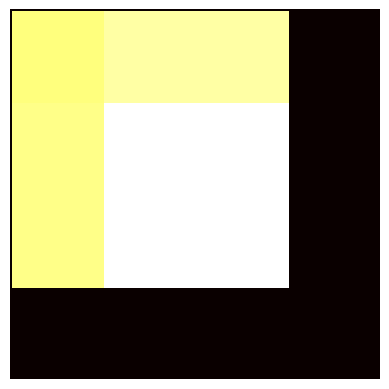

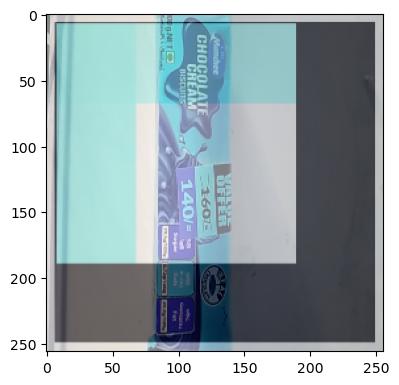

In [9]:
all_data = "../../data/all_data"
data_path = "D:/ORG India/data/all_data/30311-ceylon biscuits limited-munchee chocolate cream#1.png"
query_data ="D:/ORG India/data/all_data/30311-ceylon biscuits limited-munchee chocolate cream#1.png"
mac = MAC(4)
mac.featuremodel()

    # The model for feature extraction
query = cv2.imread(query_data) #D:\Rohit\ORG India\images\image_effect_HUc1.png
query = cv2.resize(query, (200, 200))
#Generating Saliency Graph in the output folders
saliency_matrix = generate_saliency_matrix(query,mac.extractfeature,mac.create_source_embedding_from_cvimage,mac.scoring_function,100,50,use_pil=False)
plot_saliency_map(saliency_matrix,data_path)

    